# Using GANs to Generate New Artwork

## Background

One use of generative adversarial networks (GANs) is to generate new images from a set of existing images. I do some generative art and recently made a collection of 600 pieces. Can a GAN be used to generate novel, high-fidelity images in the same style? Not just can it create a composite of the existing images, but can it learn the style and create something entirely new? Something that I hadn't thought of?


## Structure of GAN to generate new images
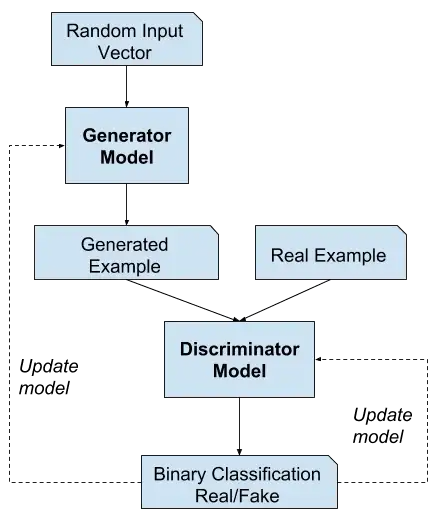

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display
import PIL

In [4]:
def tensor_to_image(tensor):
    # displays a tensor as a 3-channel image
    tensor = tensor*127.5+127.5
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [5]:
def show_batch(image_batch):
    examples = list(image_batch.as_numpy_iterator())
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(tensor_to_image(examples[0][n])) # colour
        plt.axis("off")

## EDA

The dataset consists of 600 400x500 3-channel original artworks that I created (these were resized from 4000x5000 originally). There is a bit of a border that I cropped off and I resized them to 64x64 (and later 128x128) pixels. Finally, they are normalized to between -1.0 and 1.0. Some examples are shown below. 

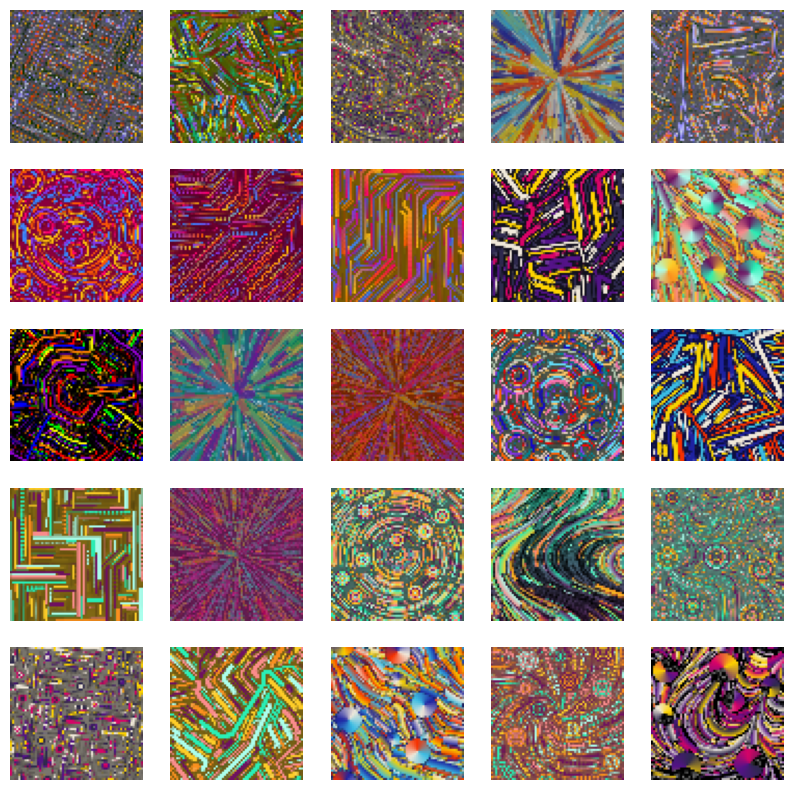

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
ARTWORK_PATH = tf.io.gfile.glob('./Field Trip/*.png')

OUTPUT_CHANNELS = 3
IMAGE_SIZE = [64, 64]
noise_dim = 100

def decode_image(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.crop_to_bounding_box(image, 20+50, 20, 360, 360)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
#     image = tf.reshape(image, [64, 64, 3])
    return image

artwork_path_ds = tf.data.Dataset.list_files(ARTWORK_PATH)

artwork_ds = artwork_path_ds.map(decode_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


show_batch(artwork_ds)

# Modeling

## Attempt 1

In [29]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 64, 64, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(OUTPUT_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, *IMAGE_SIZE, OUTPUT_CHANNELS)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[*IMAGE_SIZE, OUTPUT_CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = make_generator_model()
generator.summary()
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 65536)             6553600   
                                                                 
 batch_normalization_10 (Bat  (None, 65536)            262144    
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 65536)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 8, 8, 512)        13107200  
 ranspose)                                                       
                                                                 
 batch_normalization_11 (Bat  (None, 8, 8, 512)       

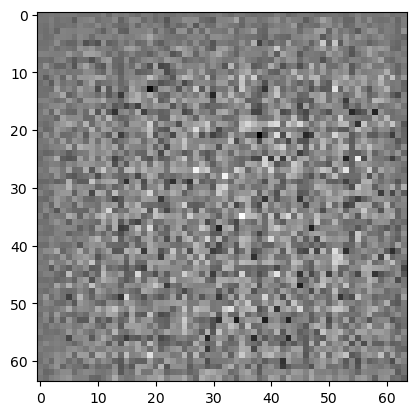

In [30]:
# Create a random noise and generate a sample

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [20]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00014089]], dtype=float32)>

In [33]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
checkpoint_dir = './ft-training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
# tf.function annotation causes the function to be "compiled" as part of the training
@tf.function
def train_step(images):
    # 1 - Create a random noise to feed it into the model for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [38]:
def train(dataset, epochs, starting_epoch):
    # A. For each epoch, do the following:
    for epoch in range(starting_epoch, starting_epoch + epochs):
        print(f"Epoch: {epoch}/{starting_epoch + epochs}")
        start = time.time()
        # 1 - For each batch of the epoch, 
        for image_batch in dataset:
            # 1.a - run the custom "train_step" function we just declared above
            train_step(image_batch)

        # 2 - Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 3 - Save the model every 5 epochs as 
        # a checkpoint, which we will use later
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # 4 - Print out the completed epoch no. and the time spent
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # B. Generate a final image after the training is completed
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    # 1 - Generate images
    predictions = model(test_input, training=False)
    # 2 - Plot the generated images
    fig = plt.figure(figsize=(12,12))
    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow(tensor_to_image(predictions[i]))
#         plt.imshow(predictions[i], cmap='gray')
        plt.axis('off')
    # 3 - Save the generated images
    plt.savefig('./ft_generated/image_at_epoch_{:05d}.png'.format(epoch))
    plt.show()

In [25]:
EPOCHS = 5000
# We will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF)
num_examples_to_generate = 9

seed = tf.random.normal([num_examples_to_generate, noise_dim])

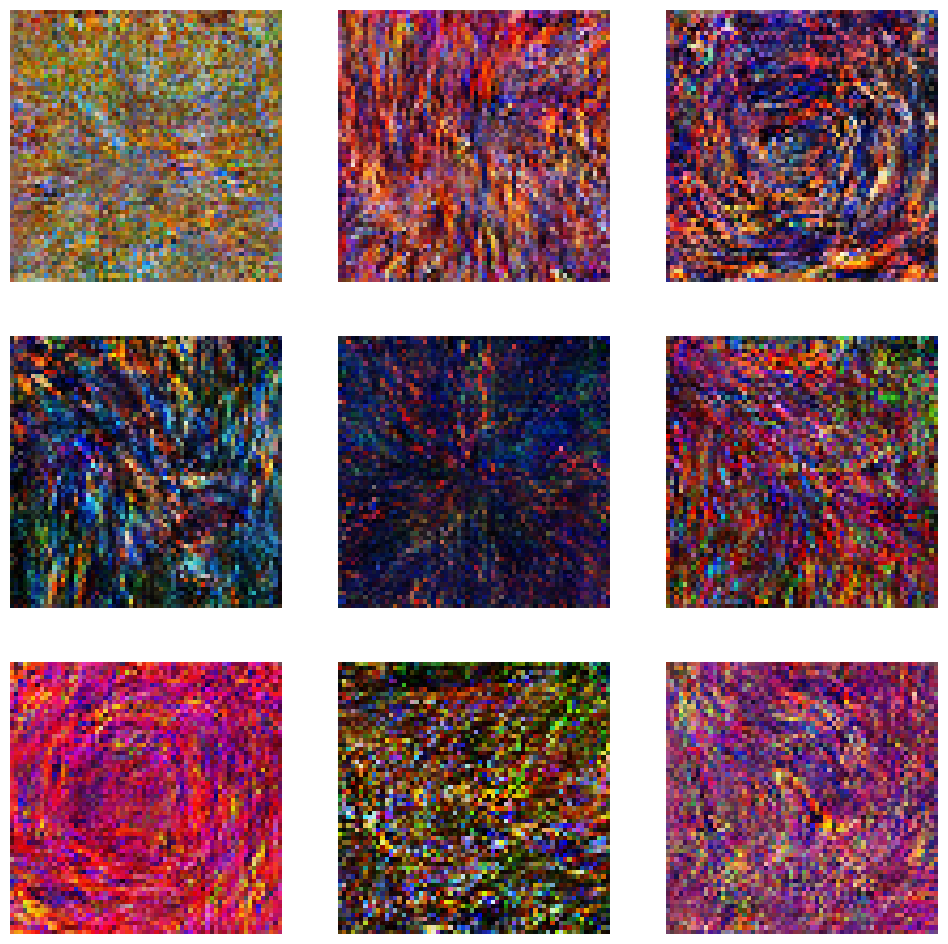

In [39]:
train(artwork_ds, 20000, 5000)
# train(painting_ds, 100)

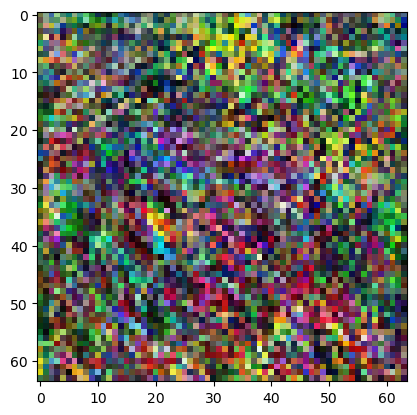

In [40]:
test = tf.random.normal([1, noise_dim])
plt.imshow(tensor_to_image(generator(test, training=False)))

This is a good start, but in hindsight the model was needlessly complex (24 million parameters in the generator) and only 64x64x3 pixels. Let's see if we can do better.

## Attempt 2

Let's try a slightly different architecture

In [74]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(filters=num_filters, kernel_size=kernel_size, kernel_initializer=w_init,
                        padding="same", strides=strides, use_bias=False)(inputs)
    if bn:
         x = BatchNormalization()(x)
         x = LeakyReLU(alpha=0.2)(x)
    return x

def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(filters=num_filters, kernel_size=kernel_size, kernel_initializer=w_init,
               padding=padding, strides=strides)(inputs)
    if activation:
         x = LeakyReLU(alpha=0.2)(x)
         x = Dropout(0.3)(x)
    return x

In [75]:
def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMAGE_SIZE[0] // output_strides
    w_output = IMAGE_SIZE[1] // output_strides
    noise = Input(shape=(latent_dim,), name="generator_noise_input")
    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, 16 * filters))(x)
    for i in range(1, 5):
        x = deconv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2, bn=True)
    x = conv_block(x, num_filters=3, kernel_size=5, strides=1, activation=False)
    fake_output = Activation("tanh")(x)
    return Model(noise, fake_output, name="generator")

def build_discriminator():
    f = [2**i for i in range(4)]
    image_input = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], OUTPUT_CHANNELS))
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMAGE_SIZE[0] // output_strides
    w_output = IMAGE_SIZE[1] // output_strides
    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)
    x = Flatten()(x)
    x = Dense(1)(x)
    return Model(image_input, x, name="discriminator")

class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) 
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))
            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            ## Train the discriminator
            labels = tf.ones((batch_size, 1))
            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            ## Train the generator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            misleading_labels = tf.ones((batch_size, 1))
            with tf.GradientTape() as gtape:
                predictions = self.discriminator(self.generator(random_latent_vectors))
                g_loss = self.loss_fn(misleading_labels, predictions)
            grads = gtape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
            return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

In [77]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    fig = plt.figure(figsize=(12,12))
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])

    filename = f"ft-generated_attempt2/generated_plot_epoch-{epoch+1}.png"
    plt.savefig(filename)
    plt.show()

In [82]:
## Hyperparameters
batch_size = 128
latent_dim = 128

num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, latent_dim])

d_model = build_discriminator()
g_model = build_generator(latent_dim)
d_model.summary()
g_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_78 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_148 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 dropout_64 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_149 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 dropout_65 (Dropout)        (None, 16, 16, 128)     

In [ ]:
gan = GAN(d_model, g_model, latent_dim)
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

checkpoint_dir = './ft_attempt2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                 discriminator_optimizer=d_optimizer,
                                 generator=g_model,
                                 discriminator=d_model)
num_epochs = 25000
start_epoch = 0
for epoch in range(start_epoch, start_epoch + num_epochs):
    print(f"Epoch: {epoch}/{start_epoch + num_epochs}")
    gan.fit(artwork_ds, epochs=1)
#     g_model.save("ft_attempt2/g_model.h5")
#     d_model.save("ft_attempt2/d_model.h5")
    if (epoch + 1) % 25 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    n_samples = 25
#     noise = np.random.normal(size=(n_samples, latent_dim))
    examples = g_model.predict(seed)
    display.clear_output(wait=True)
    save_plot(examples, epoch, int(np.sqrt(num_examples_to_generate)))

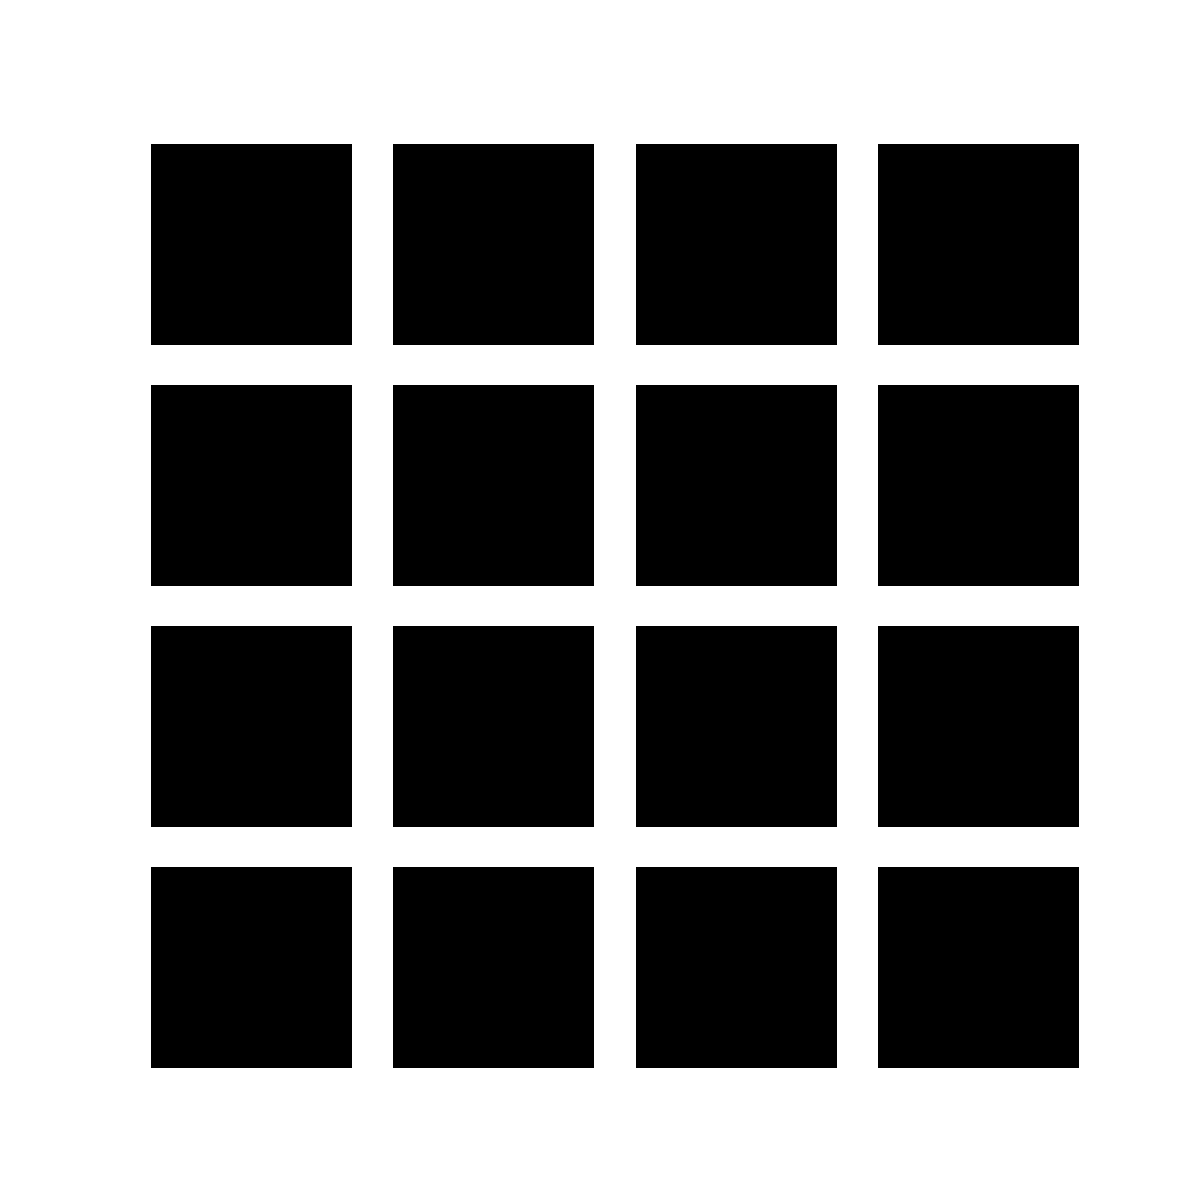<br>

This model failed to converge and we get all black images. 

## Attempt 3

Let's try yet another different architecture, and add some noise to the discriminator that decreases as time goes on

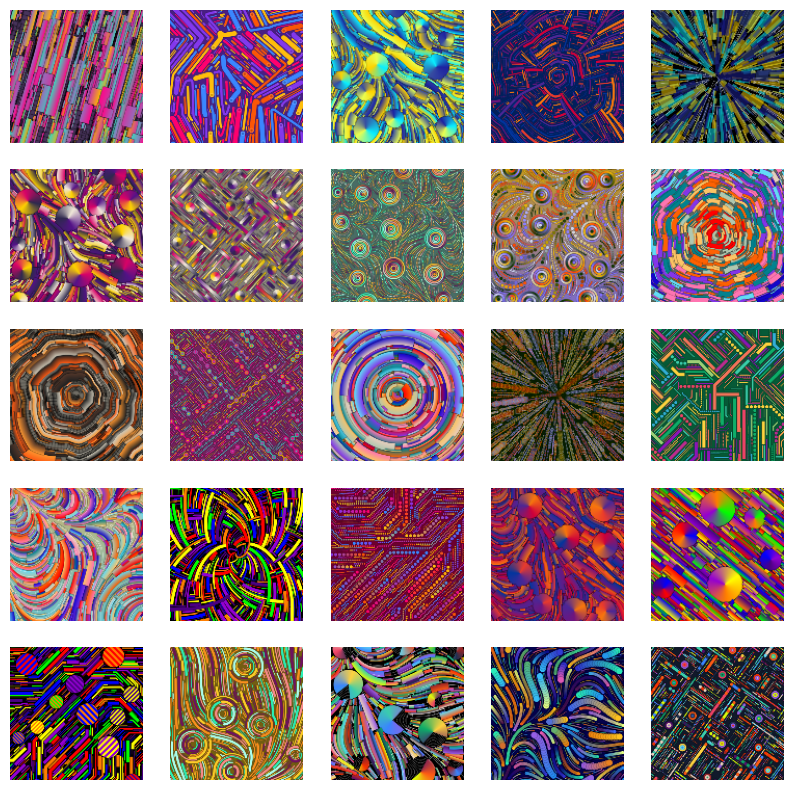

In [10]:
ARTWORK_PATH = tf.io.gfile.glob('./Field Trip/*.png')

OUTPUT_CHANNELS = 3
IMAGE_SIZE = [128, 128]
noise_dim = 100

def decode_image(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.crop_to_bounding_box(image, 20+50, 20, 360, 360)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
#     image = tf.reshape(image, [64, 64, 3])
    return image

artwork_path_ds = tf.data.Dataset.list_files(ARTWORK_PATH)

artwork_128_ds = artwork_path_ds.map(decode_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


show_batch(artwork_128_ds)

In [11]:
def upsample(x, nfilters, bn=True, drpo=True):
    x = layers.Conv2DTranspose(nfilters, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    if drpo:
        x = layers.Dropout(0.3)(x)
    return x

def get_generator():
    inp = layers.Input(shape = (noise_dim,))

    x = layers.Dense(4*4*512, use_bias=False)(inp)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Reshape((4,4,512))(x) # (4, 4, 512)

    x = upsample(x, 512)             # (8, 8, 512)
    x = upsample(x, 256)             # (16, 16, 256)
    x = upsample(x, 128)             # (32, 32, 128)
    x = upsample(x, 64, drpo=False)  # (64, 64, 64)

    x = layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(x)
    x = layers.Activation('tanh')(x) # (128, 128, 3)

    model = tf.keras.Model(inputs=inp, outputs=x)
    return model

g = get_generator()
g.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
re_lu (ReLU)                 (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         419430

Adds noise to discriminator

In [12]:
def downsample(x, nfilters, bn=True, strides=(2,2)):
    x = layers.GaussianNoise(0.1)(x)
    x = layers.Conv2D(nfilters, kernel_size=(4,4), strides=strides, padding='same', use_bias=False)(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU()(x)
    return x

def get_discriminator():
    inp = layers.Input(shape=(128,128,3))

    x = downsample(inp, 32, bn=False, strides=(1,1)) # (128, 128, 32)
    x = downsample(x, 64)               # (64, 64, 64)
    x = downsample(x, 128)              # (32, 32, 128)
    x = downsample(x, 256)              # (16, 16, 256)
    x = downsample(x, 512)              # (8, 8, 512)

    x = layers.GaussianNoise(0.1)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation=None)(x)

    model = tf.keras.Model(inputs=inp, outputs=x)
    return model

d = get_discriminator()
d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      1536      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        32768     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)        256 

In [45]:
criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # real_loss = criterion(tf.ones_like(real_output), real_output)
    # fake_loss = criterion(tf.zeros_like(fake_output), fake_output)
    real_loss = criterion(tf.random.uniform(real_output.shape, minval=0.9, maxval=1), real_output)
    fake_loss = criterion(tf.random.uniform(fake_output.shape, minval=0, maxval=0.1), fake_output)
    return real_loss + fake_loss


def generator_loss(fake_output):
    return criterion(tf.ones_like(fake_output), fake_output)

In [30]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
noise_dim = 100
BATCH_SIZE = 128

In [46]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])       # try truncating the normal distribution
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = g(noise, training=True)

        real_output = d(images, training=True)
        fake_output = d(generated, training=True)

        gen_loss = generator_loss(fake_output)
        scaled_gen_loss = gen_opt.get_scaled_loss(gen_loss)
        disc_loss = discriminator_loss(real_output, fake_output)
        scaled_disc_loss = disc_opt.get_scaled_loss(disc_loss)
    gen_grads = gen_opt.get_unscaled_gradients(gen_tape.gradient(scaled_gen_loss, g.trainable_variables))
    disc_grads = disc_opt.get_unscaled_gradients(disc_tape.gradient(scaled_disc_loss, d.trainable_variables))

    gen_opt.apply_gradients(zip(gen_grads, g.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grads, d.trainable_variables))
    return gen_loss, disc_loss

In [36]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    fig = plt.figure(figsize=(12,12))
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])

    filename = f"ft-generated_attempt4/generated_plot_epoch-{epoch+1:05d}.png"
    plt.savefig(filename)
    plt.show()

In [47]:
checkpoint_dir = '/attempt4'
checkpoint = tf.train.Checkpoint(gen_opt=gen_opt, disc_opt=disc_opt, g=g, d=d)
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)
manager.restore_or_initialize()

In [ ]:
gen_opt = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(2e-4, beta_1=0.5))
disc_opt = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(2e-4, beta_1=0.5))

GLOBAL_STEPS = 0

decay_rate = 0.005

def train(dataset):
    global GLOBAL_STEPS
    for idx, batch in enumerate(dataset):
        gen_loss, disc_loss = train_step(batch)
        GLOBAL_STEPS+=1

num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
EPOCHS = 1000
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1} of {EPOCHS}.")
    train(artwork_128_ds)
    for lyr in d.layers:
        if type(lyr) == layers.GaussianNoise:
            if lyr.stddev > 0:
                lyr.stddev -= decay_rate
            else:
                lyr.stddev = 0
    examples = g.predict(seed)
    display.clear_output(wait=True)
    save_plot(examples, epoch, int(np.sqrt(num_examples_to_generate)))
# manager.save()
# os.system(f'cmd /c \"PowerShell -File \"C:\\Users\\Andrew\\OneDrive\\Programming\\Email Notification.ps1\"\"')

In [13]:
# d.save("./attempt4/d.h5")
# g.save("./attempt4/g.h5")
d.load_weights("./attempt4/d.h5")
g.load_weights("./attempt4/g.h5")

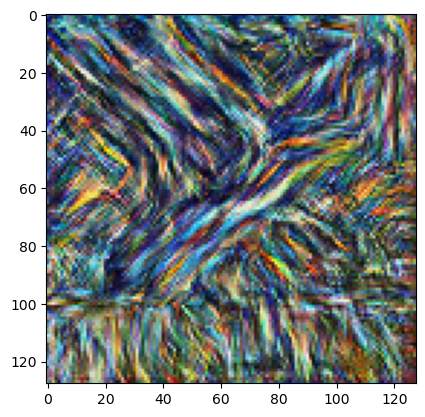

In [48]:
seed = tf.random.normal([1, noise_dim])
plt.imshow(tensor_to_image(g.predict(seed)))

Let's test the discriminator

In [49]:
print(f"Discriminator output on generated image: {d(g(seed)).numpy()[0][0]}")

sample_images = next(iter(artwork_128_ds))
print(f"Discriminator output on training image: {d(sample_image)[0][0].numpy()}")

Discriminator output on generated image: -2.8171463012695312
Discriminator output on training image: 1.954906702041626


# Conclusion

- An overly complex model was slow but generated images resembling my original artwork
- A simple model failed to converge
- Another simple model but with noise added to discriminator worked well. The output wasn't stable, though.
- The same model but with decreasing noise also wasn't stable (I think this is because GANs are inherently unstable, there is a back-and-forth between the discriminator and generator)
- The discriminator on this model was positive for a real image and negative for a generated image
- The GAN created Frankenstein images that are kind of interesting but are limited to combinations of what already exists in the training set. 

# References

https://www.kaggle.com/code/amyjang/creating-romantic-period-art-w-tensorflow-dcgan/notebook<br>
https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b<br>
https://medium.com/analytics-vidhya/dcgan-implementing-deep-convolutional-generative-adversarial-network-in-tensorflow-idiot-41b2ddf9eddb<br>
https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/<br>